In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from scipy.ndimage import label
import numpy as np


def initialize_lattice(L, p):
    # Generate lattice where each site is occupied with probability p
    return (np.random.rand(L, L) < p).astype(int)


def burning_method(lattice):
    L = lattice.shape[0]
    visited = np.zeros_like(lattice, dtype=bool)
    frontier = set([(0, j) for j in range(L) if lattice[0, j] == 1])

    while frontier:
        i, j = frontier.pop()
        if i == L - 1:  # Reached the last row
            return True
        visited[i, j] = True
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < L and 0 <= nj < L and not visited[ni, nj] and lattice[ni, nj] == 1:
                frontier.add((ni, nj))

    return False


def hoshen_kopelman(lattice):
    labeled_lattice, num_clusters = label(lattice)
    cluster_sizes = np.bincount(labeled_lattice.ravel())[
        1:]  # Exclude background
    return labeled_lattice, cluster_sizes


def monte_carlo_simulation(L, T, p_values):
    results = []
    for p in p_values:
        Pflow = 0
        smax_avg = 0
        for _ in range(T):
            lattice = initialize_lattice(L, p)
            if burning_method(lattice):
                Pflow += 1
            _, cluster_sizes = hoshen_kopelman(lattice)
            if cluster_sizes.size > 0:
                smax_avg += cluster_sizes.max()

        Pflow /= T
        smax_avg /= T
        results.append((p, Pflow, smax_avg))
    return results


def cluster_size_distribution(lattice):
    _, cluster_sizes = hoshen_kopelman(lattice)
    distribution = Counter(cluster_sizes)
    del distribution[0]  # Remove background clusters (size 0)
    return distribution


def monte_carlo_cluster_distribution(L, T, p_values):
    distributions = {}
    for p in p_values:
        total_distribution = Counter()
        for _ in range(T):
            lattice = initialize_lattice(L, p)
            distribution = cluster_size_distribution(lattice)
            total_distribution += Counter(distribution)

        # Normalize distributions
        distributions[p] = {s: n / T for s, n in total_distribution.items()}
    return distributions


def save_results(results, filename):
    with open(filename, "w") as f:
        for p, Pflow, smax in results:
            f.write(f"{p:.2f}  {Pflow:.4f}  {smax:.2f}\n")


def save_cluster_distribution(distributions, L, T):
    for p, distribution in distributions.items():
        filename = f"Dist-p{p:.2f}L{L}T{T}.txt"
        with open(filename, "w") as f:
            for s, n in sorted(distribution.items()):
                f.write(f"{s}  {n:.4f}\n")


def plot_percolation_probability(p_values, Pf_low, L, T):

    plt.figure(figsize=(8, 5))
    plt.plot(p_values, Pf_low, 'o-',
             label="Probability of Percolation ($P_{flow}$)")
    plt.xlabel("Occupation Probability (p)")
    plt.ylabel("$P_{flow}$")
    plt.title("Percolation Probability as a Function of p")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    # Save plot with filename
    plt.savefig(f"PercolationProbability-L{L}T{T}.png")
    plt.show()


def plot_avg_max_cluster_size(p_values, avg_smax, L, T):

    plt.figure(figsize=(8, 5))
    plt.plot(p_values, avg_smax, 's-', color='orange',
             label="Average Maximum Cluster Size ($⟨s_{max}⟩$)")
    plt.xlabel("Occupation Probability (p)")
    plt.ylabel("$⟨s_{max}⟩$")
    plt.title("Average Maximum Cluster Size as a Function of p")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig(f"AvgMaxCluster-L{L}T{T}.png")  # Save plot with filename
    plt.show()


def plot_selected_cluster_distributions(distributions, selected_p_values, L, T):
    """
    Plot cluster size distributions for selected probabilities only.
    
    Args:
        distributions: Dictionary with probabilities as keys and cluster size distributions as values.
        selected_p_values: List of specific probabilities to plot.
    """
    plt.figure(figsize=(8, 6))

    for p in selected_p_values:
        if p in distributions:
            distribution = distributions[p]
            sizes, counts = zip(*sorted(distribution.items()))
            plt.plot(sizes, counts, marker='o', label=f"p = {p:.2f}")
        else:
            print(f"Warning: Distribution for p = {p} not found.")

    plt.xlabel("Cluster Size (s)")
    plt.ylabel("n(s, p, L)")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.title("Cluster Size Distribution for Selected p Values")
    plt.tight_layout()
    plt.savefig(f"ClusterSizeDistribution-L{L}T{T}.png")
    plt.show()

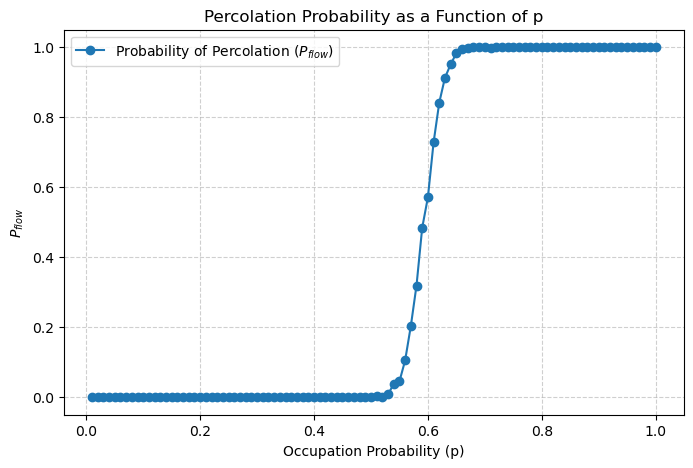

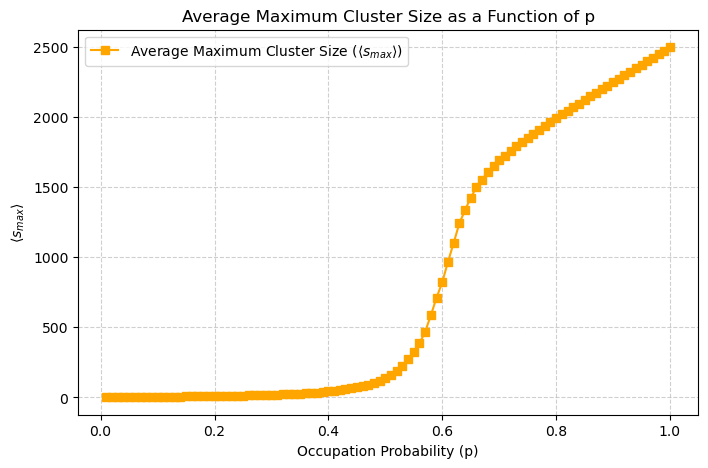

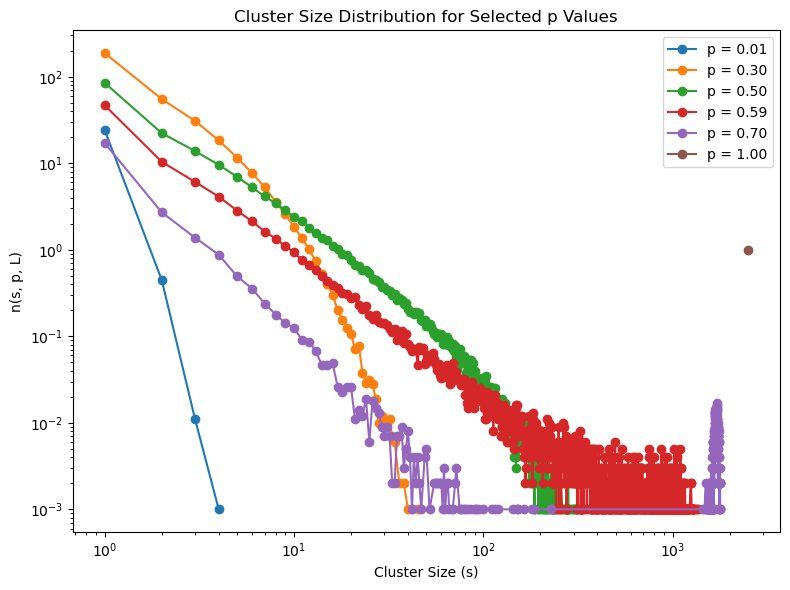

In [6]:
def main():
    # Load parameters
    with open("perc-ini.txt", "r") as f:
        L = int(f.readline().split()[0])
        T = int(f.readline().split()[0])
        p0 = float(f.readline().split()[0])
        pk = float(f.readline().split()[0])
        dp = float(f.readline().split()[0])

    p_values = np.arange(p0, pk + dp, dp)
    p_values = np.round(p_values, 6)

    # Run Monte Carlo Simulation
    results = monte_carlo_simulation(L, T, p_values)
    save_results(results, f"Ave-L{L}T{T}.txt")
    
    # Extract percolation probabilities and max cluster sizes
    p_values, Pf_low, avg_smax = zip(*results)

    # Plot and save figures
    plot_percolation_probability(p_values, Pf_low, L, T)
    plot_avg_max_cluster_size(p_values, avg_smax, L, T)


    # Cluster Size Distributions
    distributions = monte_carlo_cluster_distribution(L, T, p_values)
    save_cluster_distribution(distributions, L, T)

    # Selected probabilities
    selected_p_values = [p0, 0.3, 0.5, 0.59, 0.7, pk]
    plot_selected_cluster_distributions(distributions, selected_p_values, L, T)


if __name__ == "__main__":
    main()